In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = scipy.io.loadmat('dataset/train_32x32.mat')

In [3]:
train

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Mon Dec  5 21:09:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[[[ 33,  84,  19, ...,  92, 190, 216],
          [ 30,  76,  54, ...,  78, 188, 217],
          [ 38,  59, 110, ..., 101, 191, 212]],
 
         [[ 15,  86,  20, ...,  94, 205, 221],
          [ 23,  73,  52, ...,  82, 203, 222],
          [ 19,  66, 111, ..., 105, 206, 217]],
 
         [[ 15,  77,  25, ..., 114, 220, 226],
          [ 17,  78,  57, ..., 101, 218, 227],
          [ 19,  56, 116, ..., 125, 220, 221]],
 
         ...,
 
         [[ 72,  90,  65, ..., 200, 229, 200],
          [ 65,  78, 144, ..., 201, 231, 199],
          [ 56,  69, 223, ..., 203, 224, 191]],
 
         [[ 82,  88,  78, ..., 192, 229, 193],
          [ 77,  77, 148, ..., 193, 229, 188],
          [ 57,  67, 218, ..., 195, 224, 182]],
 
         [[ 89,  88,  98, ..., 190, 229, 197],
          [ 79,  78, 158, ..., 191, 228, 189],
          [ 59,  66, 220, 

In [4]:
X_train = train['X']  
y_train = train['y']  

print(X_train.shape)
print(y_train.shape)

(32, 32, 3, 73257)
(73257, 1)


In [5]:
y_train[:10]

array([[1],
       [9],
       [2],
       [3],
       [2],
       [5],
       [9],
       [3],
       [3],
       [1]], dtype=uint8)

In [6]:
X_train = np.transpose(X_train, (3, 0, 1, 2))  # transpose axes into (73257, 32, 32, 3)

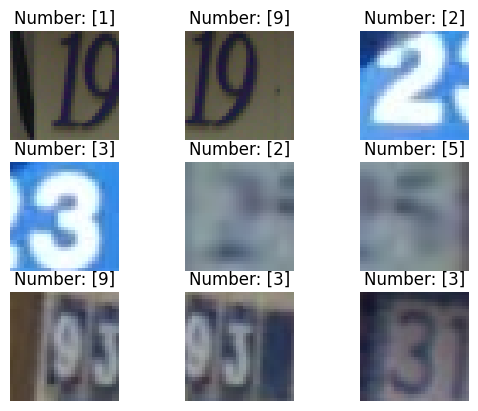

In [7]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Number: {y_train[i]}")
    plt.axis('off')  

In [8]:
y_train = y_train.flatten()

In [9]:
unique_classes, counts = np.unique(y_train, return_counts=True)

In [10]:
sample_counts_train = dict(zip(unique_classes, counts))
sample_counts_train

{1: 13861,
 2: 10585,
 3: 8497,
 4: 7458,
 5: 6882,
 6: 5727,
 7: 5595,
 8: 5045,
 9: 4659,
 10: 4948}

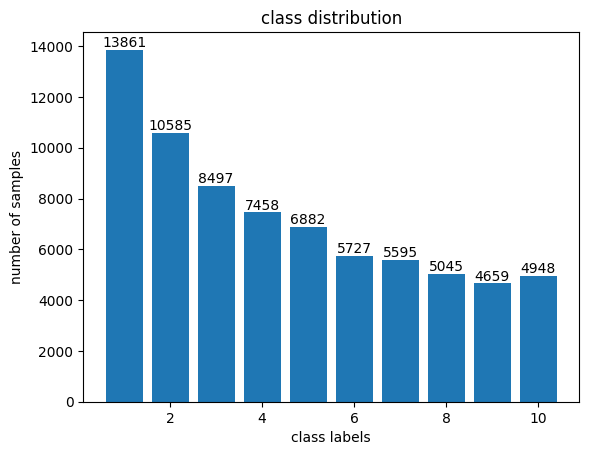

In [169]:
plt.bar(unique_classes, counts)

# Adding labels and title
plt.xlabel('class labels')  
plt.ylabel('number of samples')  
plt.title('class distribution')  

# Adding value labels on top of each bar
for i, count in enumerate(counts):
    plt.text(unique_classes[i], count + 0.5, str(count), ha='center', va='bottom')


In [12]:
#expand each class to 7000 samples
extra = scipy.io.loadmat('dataset/extra_32x32.mat')

In [13]:
X_extra = extra['X']  
y_extra = extra['y'] 

In [14]:
print(X_extra.shape)
print(y_extra.shape)

(32, 32, 3, 531131)
(531131, 1)


In [15]:
X_extra = np.transpose(X_extra, (3, 0, 1, 2))  # transpose axes into (73257, 32, 32, 3)

In [16]:
y_extra = y_extra.flatten()
unique_classes, counts_extra = np.unique(y_extra, return_counts=True)
sample_counts_extra = dict(zip(unique_classes, counts_extra))

In [17]:
sample_counts_extra

{1: 90560,
 2: 74740,
 3: 60765,
 4: 50633,
 5: 53490,
 6: 41582,
 7: 43997,
 8: 35358,
 9: 34456,
 10: 45550}

<BarContainer object of 10 artists>

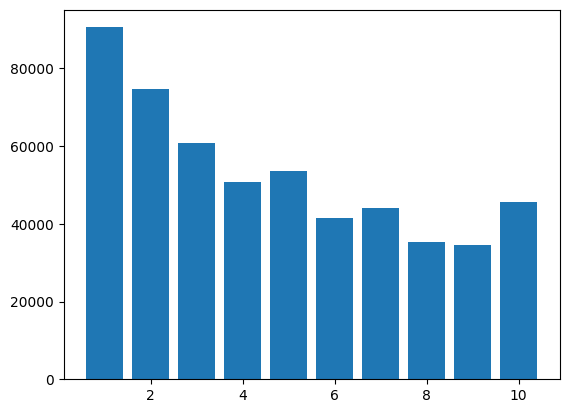

In [18]:
plt.bar(unique_classes, counts_extra)

In [19]:
target_samples_number = 7000

In [20]:
X_train_balanced = []
y_train_balanced = []

for class_label in unique_classes:
    num_missing = target_samples_number - sample_counts_train[class_label]

    extra_indices = np.where(y_extra == class_label)[0]
    
    X_class = X_train[y_train == class_label]
    y_class = y_train[y_train == class_label]

    if num_missing > 0:
        X_class = np.concatenate((X_class, X_extra[extra_indices[:num_missing]]), axis=0)
        y_class = np.concatenate((y_class, y_extra[extra_indices[:num_missing]]), axis=0)

    # If size> 7000 randomly select 7000 samples
    if len(y_class) > target_samples_number:
        indices = np.random.choice(len(y_class), target_samples_number, replace=False)
        X_class = X_class[indices]
        y_class = y_class[indices]

    X_train_balanced.append(X_class)
    y_train_balanced.append(y_class)


X_train_balanced = np.concatenate(X_train_balanced, axis=0)
y_train_balanced = np.concatenate(y_train_balanced, axis=0)


In [21]:
unique_classes, counts_balanced= np.unique(y_train_balanced, return_counts=True)
dict(zip(unique_classes, counts_balanced))

{1: 7000,
 2: 7000,
 3: 7000,
 4: 7000,
 5: 7000,
 6: 7000,
 7: 7000,
 8: 7000,
 9: 7000,
 10: 7000}

In [22]:
import torchvision.transforms as transforms

In [23]:
# less transforms for val dataset
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.5], std=[0.5])  
])

In [24]:
# more transforms for train dataset
transform_augmented = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomRotation(10),  
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), 
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [25]:
test = scipy.io.loadmat('dataset/test_32x32.mat')

In [26]:
X_test = test['X']  
y_test = test['y'] 

print(X_test.shape)
print(y_test.shape)

(32, 32, 3, 26032)
(26032, 1)


In [27]:
X_test = np.transpose(X_test, (3, 0, 1, 2))  # transpose axes into (73257, 32, 32, 3)

y_test = y_test.flatten()

unique_classes, counts_test = np.unique(y_test, return_counts=True)
dict(zip(unique_classes, counts_test))

{1: 5099,
 2: 4149,
 3: 2882,
 4: 2523,
 5: 2384,
 6: 1977,
 7: 2019,
 8: 1660,
 9: 1595,
 10: 1744}

In [28]:
print(X_test.shape)
print(y_test.shape)

(26032, 32, 32, 3)
(26032,)


In [29]:
import torch

In [30]:
def apply_transform(X, y, transform):
    X_transformed = torch.stack([transform(img) for img in X])  
    y_transformed = torch.tensor(y, dtype=torch.long)  
    return X_transformed, y_transformed


In [31]:
X_train_transformed, y_train_transformed = apply_transform(X_train_balanced, y_train_balanced, transform_augmented)
X_test_transformed, y_test_transformed = apply_transform(X_test, y_test, transform)

In [32]:
print(X_train_transformed.shape) 
print(y_train_transformed.shape)  

torch.Size([70000, 1, 32, 32])
torch.Size([70000])


In [33]:
y_train_transformed = y_train_transformed - 1
y_test_transformed = y_test_transformed - 1

In [54]:
from sklearn.model_selection import train_test_split

X_val, X_test_final, y_val, y_test_final = train_test_split(
    X_test_transformed, y_test_transformed, test_size=0.2, random_state=42)

In [55]:
# final test datasets left unused
print(X_test_final.shape)
print(y_test_final.shape)
print(X_val.shape)
print(y_val.shape)

torch.Size([5207, 1, 32, 32])
torch.Size([5207])
torch.Size([20825, 1, 32, 32])
torch.Size([20825])


In [36]:
from torch import nn, optim
import torch.nn.functional as F

In [37]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # calculations on the graphic processor if possible

In [71]:
class Model_1(nn.Module):
    def __init__(self):
        super(Model_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)  
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  
        self.fc2 = nn.Linear(128, 10)  
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  
        x = F.relu(self.fc1(x))
        x.dropout = self.dropout(x)
        x = self.fc2(x)  
        return x

In [72]:
class Model_2(nn.Module):
    def __init__(self):
        super(Model_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # one more conv layer
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)  
        self.batch_norm = nn.BatchNorm2d(128)  # batch normalization
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.batch_norm(x)  
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = self.fc2(x)
        return x


In [91]:
class Model_3(nn.Module):
    def __init__(self):
        super(Model_3, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # more BatchNorm
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)
        self.shortcut = nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False)  # decrease the dimension residual
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)  
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        residual = self.shortcut(x)  # shortcut to coordinate channels and sizes

        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x += residual  # Now the dimensions are equial 

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


In [41]:
import torchvision.models as models

In [44]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.handlers import ModelCheckpoint, EarlyStopping
from ignite.contrib.handlers import ProgressBar, HandlersTimeProfiler
from ignite.handlers import Checkpoint, global_step_from_engine, DiskSaver

In [94]:
# dict with models for loop iteration
model_classes = {name: cls for name, cls in globals().items() if name.startswith("Model_")}

In [47]:
from torch.utils.data import TensorDataset, DataLoader

# make datasets
train_dataset = TensorDataset(X_train_transformed, y_train_transformed)
val_dataset = TensorDataset(X_val, y_val)

# make DataLoader 
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [79]:
def train_and_evaluate(model, optimizer, lr, epochs=10):
    model.to(device)
    optimizer = optimizer(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    metrics = {"loss": Loss(criterion), "accuracy": Accuracy()}
    evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

    history = {"train_acc": [], "train_loss": [], "val_acc": [], "val_loss": []}

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(trainer):
        evaluator.run(train_loader)
        metrics = evaluator.state.metrics
        history["train_acc"].append(metrics["accuracy"] * 100)
        history["train_loss"].append(metrics["loss"])
        print(f"Epoch {trainer.state.epoch} | Train Accuracy: {metrics['accuracy'] * 100:.2f}% | Loss: {metrics['loss']:.5f}")

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_validation_results(trainer):
        evaluator.run(val_loader)
        metrics = evaluator.state.metrics
        history["val_acc"].append(metrics["accuracy"] * 100)
        history["val_loss"].append(metrics["loss"])
        print(f"Validation Accuracy: {metrics['accuracy'] * 100:.2f}% | Loss: {metrics['loss']:.5f}")

    # stop if no accuracy improvements
    stopper = EarlyStopping(patience=4, score_function=lambda eng: eng.state.metrics["accuracy"], trainer=trainer)
    evaluator.add_event_handler(Events.COMPLETED, stopper)

    # save model
    saver = Checkpoint(
        {"model": model},
        save_handler=DiskSaver("models", create_dir=True, require_empty=False),
        filename_prefix=f"best_model",
        score_name="accuracy",
        n_saved=1,
        global_step_transform=global_step_from_engine(trainer)
    )
    evaluator.add_event_handler(Events.COMPLETED, saver)

    trainer.run(train_loader, max_epochs=epochs)

    return model, history

In [96]:
# train custom models with the same hyperparameters
trained_models = []
for name, model_class in model_classes.items():
    print(f"\n{name}")
    model = model_class()
    trained_model, history = train_and_evaluate(model, optim.Adam, lr=0.001)
    trained_models.append((name, trained_model, history))


Model_1
Epoch 1 | Train Accuracy: 60.93% | Loss: 1.18648
Validation Accuracy: 73.86% | Loss: 0.86141
Epoch 2 | Train Accuracy: 69.00% | Loss: 0.95997
Validation Accuracy: 78.80% | Loss: 0.70482
Epoch 3 | Train Accuracy: 73.53% | Loss: 0.82817
Validation Accuracy: 81.03% | Loss: 0.62706
Epoch 4 | Train Accuracy: 76.30% | Loss: 0.74619
Validation Accuracy: 83.43% | Loss: 0.57229
Epoch 5 | Train Accuracy: 77.20% | Loss: 0.71081
Validation Accuracy: 84.18% | Loss: 0.53187
Epoch 6 | Train Accuracy: 79.13% | Loss: 0.66352
Validation Accuracy: 84.79% | Loss: 0.50746
Epoch 7 | Train Accuracy: 79.09% | Loss: 0.65316
Validation Accuracy: 84.67% | Loss: 0.50770
Epoch 8 | Train Accuracy: 79.83% | Loss: 0.63154
Validation Accuracy: 85.10% | Loss: 0.49803
Epoch 9 | Train Accuracy: 81.22% | Loss: 0.59582
Validation Accuracy: 86.46% | Loss: 0.46540
Epoch 10 | Train Accuracy: 81.15% | Loss: 0.59073
Validation Accuracy: 85.60% | Loss: 0.49025

Model_2
Epoch 1 | Train Accuracy: 82.84% | Loss: 0.53400
Va

In [99]:
trained_models

[('Model_1',
  Model_1(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout): Dropout(p=0.3, inplace=False)
    (fc1): Linear(in_features=4096, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  ),
  {'train_acc': [60.927142857142854,
    69.00428571428571,
    73.53142857142856,
    76.3,
    77.19571428571429,
    79.13142857142857,
    79.09142857142857,
    79.82571428571428,
    81.21714285714286,
    81.15142857142857],
   'train_loss': [1.1864828125,
    0.9599698660714285,
    0.8281663504464286,
    0.7461878348214286,
    0.71080859375,
    0.6635236607142857,
    0.6531555245535714,
    0.63153984375,
    0.5958178571428572,
    0.5907335379464286],
   'val_acc': [73.86210869982716,
    78.79777222969079,
    81.02554253888997,
   

In [102]:
different_models_train_and_val_results = trained_models.copy()

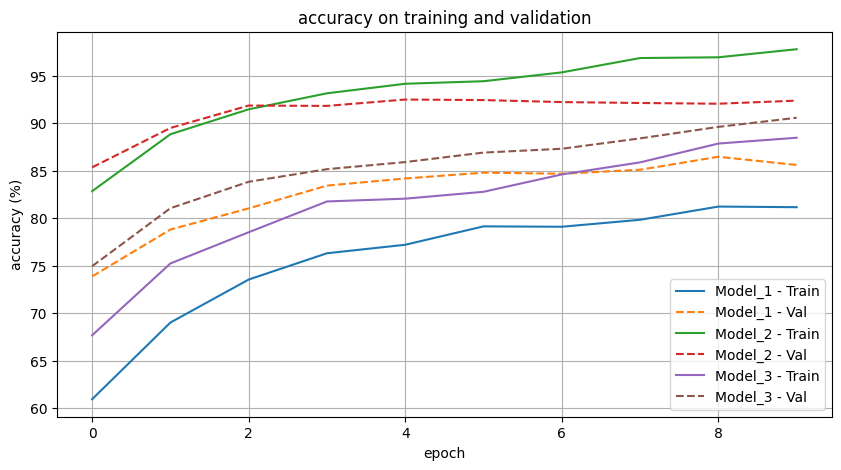

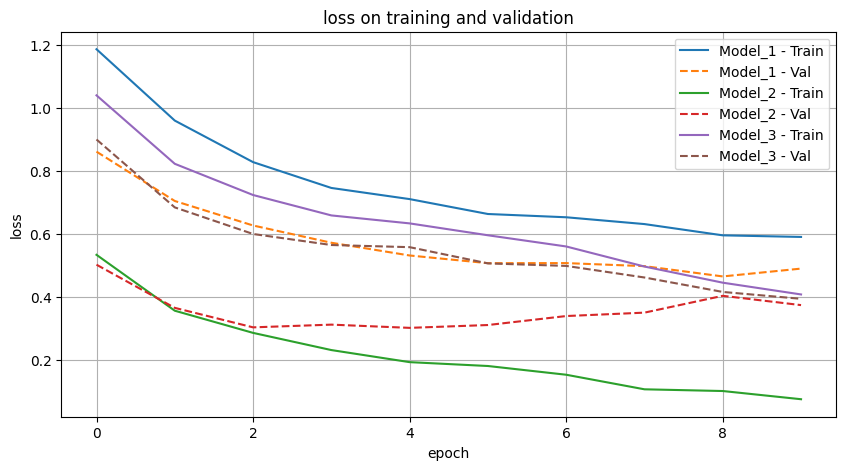

In [155]:
# accuracy on training and validation
plt.figure(figsize=(10, 5))
for model_name, _, data in different_models_train_and_val_results: 
    plt.plot(data["train_acc"], label=f"{model_name} - Train")
    plt.plot(data["val_acc"], linestyle="dashed", label=f"{model_name} - Val")
plt.xlabel("epoch")
plt.ylabel("accuracy (%)")
plt.title("accuracy on training and validation")
plt.legend()
plt.grid()
plt.show()

# loss on training and validation
plt.figure(figsize=(10, 5))
for model_name, _, data in different_models_train_and_val_results: 
    plt.plot(data["train_loss"], label=f"{model_name} - Train")
    plt.plot(data["val_loss"], linestyle="dashed", label=f"{model_name} - Val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss on training and validation")
plt.legend()
plt.grid()
plt.show()

In [104]:
# pass dropout as a parameter
class Model_1_whit_dropout(nn.Module):
    def __init__(self, dropout=0.3):  
        super(Model_1_whit_dropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)  
        self.dropout = nn.Dropout(dropout)  
        self.fc1 = nn.Linear(64 * 8 * 8, 128)  
        self.fc2 = nn.Linear(128, 10)  
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  
        x = self.fc2(x)  
        return x

In [107]:
import itertools

# Hyperparameters 
learning_rates = [0.001, 0.05]
optimizers = [optim.Adam, optim.SGD]
dropout_rates = [0.4, 0.5]

In [108]:
for lr, opt, dropout in itertools.product(learning_rates, optimizers, dropout_rates):
    print(f"\n Model_1_whit_dropout | LR={lr}, Optimizer={opt.__name__}, Dropout={dropout}")
    model = Model_1_whit_dropout(dropout=dropout)  
    train_and_evaluate(model, opt, lr)


 Model_1_whit_dropout | LR=0.001, Optimizer=Adam, Dropout=0.3
Epoch 1 | Train Accuracy: 67.59% | Loss: 1.01173
Validation Accuracy: 79.39% | Loss: 0.71906
Epoch 2 | Train Accuracy: 73.96% | Loss: 0.84486
Validation Accuracy: 82.37% | Loss: 0.62359
Epoch 3 | Train Accuracy: 76.27% | Loss: 0.73984
Validation Accuracy: 84.16% | Loss: 0.54786
Epoch 4 | Train Accuracy: 78.57% | Loss: 0.68813
Validation Accuracy: 85.23% | Loss: 0.51726
Epoch 5 | Train Accuracy: 79.96% | Loss: 0.63533
Validation Accuracy: 85.77% | Loss: 0.49003
Epoch 6 | Train Accuracy: 81.23% | Loss: 0.60972
Validation Accuracy: 86.04% | Loss: 0.48281
Epoch 7 | Train Accuracy: 81.91% | Loss: 0.58503
Validation Accuracy: 86.38% | Loss: 0.47493
Epoch 8 | Train Accuracy: 82.59% | Loss: 0.55150
Validation Accuracy: 86.65% | Loss: 0.46172
Epoch 9 | Train Accuracy: 83.30% | Loss: 0.53563
Validation Accuracy: 87.23% | Loss: 0.44929
Epoch 10 | Train Accuracy: 84.26% | Loss: 0.51093
Validation Accuracy: 87.50% | Loss: 0.43850

 Mode

2025-03-10 12:42:58,922 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 3 | Train Accuracy: 10.00% | Loss: 2.30777


2025-03-10 12:43:02,329 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Accuracy: 7.76% | Loss: 2.31564

 Model_1_whit_dropout | LR=0.05, Optimizer=Adam, Dropout=0.5
Epoch 1 | Train Accuracy: 10.00% | Loss: 2.30315
Validation Accuracy: 15.90% | Loss: 2.29417
Epoch 2 | Train Accuracy: 10.00% | Loss: 2.30702
Validation Accuracy: 8.51% | Loss: 2.29946
Epoch 3 | Train Accuracy: 10.00% | Loss: 2.30537


2025-03-10 12:51:22,405 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Accuracy: 8.51% | Loss: 2.31886

 Model_1_whit_dropout | LR=0.05, Optimizer=SGD, Dropout=0.3
Epoch 1 | Train Accuracy: 17.31% | Loss: 2.26237
Validation Accuracy: 22.37% | Loss: 2.25114
Epoch 2 | Train Accuracy: 56.09% | Loss: 1.30139
Validation Accuracy: 72.04% | Loss: 0.90726
Epoch 3 | Train Accuracy: 72.43% | Loss: 0.88114
Validation Accuracy: 83.33% | Loss: 0.61711
Epoch 4 | Train Accuracy: 78.63% | Loss: 0.68800
Validation Accuracy: 86.25% | Loss: 0.50780
Epoch 5 | Train Accuracy: 82.91% | Loss: 0.56291
Validation Accuracy: 88.48% | Loss: 0.44084
Epoch 6 | Train Accuracy: 83.45% | Loss: 0.53098
Validation Accuracy: 88.59% | Loss: 0.40781
Epoch 7 | Train Accuracy: 87.17% | Loss: 0.42438
Validation Accuracy: 89.78% | Loss: 0.37622
Epoch 8 | Train Accuracy: 88.07% | Loss: 0.39944
Validation Accuracy: 90.05% | Loss: 0.36519
Epoch 9 | Train Accuracy: 89.13% | Loss: 0.36365
Validation Accuracy: 90.72% | Loss: 0.34978
Epoch 10 | Train Accuracy: 90.27% | Loss: 0.32102
Validatio

# I've made a mistake here. Didn't pass training history to variable. But training takes so long. So I have to improvise 

In [127]:
log = """"Model_1_whit_dropout | LR=0.001, Optimizer=Adam, Dropout=0.3
Epoch 1 | Train Accuracy: 67.59% | Loss: 1.01173
Validation Accuracy: 79.39% | Loss: 0.71906
Epoch 2 | Train Accuracy: 73.96% | Loss: 0.84486
Validation Accuracy: 82.37% | Loss: 0.62359
Epoch 3 | Train Accuracy: 76.27% | Loss: 0.73984
Validation Accuracy: 84.16% | Loss: 0.54786
Epoch 4 | Train Accuracy: 78.57% | Loss: 0.68813
Validation Accuracy: 85.23% | Loss: 0.51726
Epoch 5 | Train Accuracy: 79.96% | Loss: 0.63533
Validation Accuracy: 85.77% | Loss: 0.49003
Epoch 6 | Train Accuracy: 81.23% | Loss: 0.60972
Validation Accuracy: 86.04% | Loss: 0.48281
Epoch 7 | Train Accuracy: 81.91% | Loss: 0.58503
Validation Accuracy: 86.38% | Loss: 0.47493
Epoch 8 | Train Accuracy: 82.59% | Loss: 0.55150
Validation Accuracy: 86.65% | Loss: 0.46172
Epoch 9 | Train Accuracy: 83.30% | Loss: 0.53563
Validation Accuracy: 87.23% | Loss: 0.44929
Epoch 10 | Train Accuracy: 84.26% | Loss: 0.51093
Validation Accuracy: 87.50% | Loss: 0.43850

 Model_1_whit_dropout | LR=0.001, Optimizer=Adam, Dropout=0.5
Epoch 1 | Train Accuracy: 54.95% | Loss: 1.35845
Validation Accuracy: 68.27% | Loss: 1.06047
Epoch 2 | Train Accuracy: 61.88% | Loss: 1.15810
Validation Accuracy: 76.19% | Loss: 0.79636
Epoch 3 | Train Accuracy: 65.36% | Loss: 1.06396
Validation Accuracy: 77.20% | Loss: 0.74785
Epoch 4 | Train Accuracy: 68.89% | Loss: 0.96769
Validation Accuracy: 79.22% | Loss: 0.68909
Epoch 5 | Train Accuracy: 71.05% | Loss: 0.91708
Validation Accuracy: 79.99% | Loss: 0.65721
Epoch 6 | Train Accuracy: 72.39% | Loss: 0.86581
Validation Accuracy: 80.93% | Loss: 0.63840
Epoch 7 | Train Accuracy: 73.66% | Loss: 0.85063
Validation Accuracy: 81.33% | Loss: 0.63854
Epoch 8 | Train Accuracy: 74.20% | Loss: 0.82241
Validation Accuracy: 80.70% | Loss: 0.64535
Epoch 9 | Train Accuracy: 75.07% | Loss: 0.80472
Validation Accuracy: 83.04% | Loss: 0.60055
Epoch 10 | Train Accuracy: 75.06% | Loss: 0.79836
Validation Accuracy: 82.14% | Loss: 0.60677

 Model_1_whit_dropout | LR=0.001, Optimizer=SGD, Dropout=0.3
Epoch 1 | Train Accuracy: 10.48% | Loss: 2.30239
Validation Accuracy: 7.97% | Loss: 2.30484
Epoch 2 | Train Accuracy: 10.55% | Loss: 2.30196
Validation Accuracy: 7.95% | Loss: 2.30395
Epoch 3 | Train Accuracy: 10.96% | Loss: 2.30161
Validation Accuracy: 8.66% | Loss: 2.30396
Epoch 4 | Train Accuracy: 11.27% | Loss: 2.30129
Validation Accuracy: 8.99% | Loss: 2.30353
Epoch 5 | Train Accuracy: 11.46% | Loss: 2.30095
Validation Accuracy: 8.58% | Loss: 2.30314
Epoch 6 | Train Accuracy: 11.80% | Loss: 2.30057
Validation Accuracy: 8.64% | Loss: 2.30310
Epoch 7 | Train Accuracy: 12.29% | Loss: 2.30019
Validation Accuracy: 8.64% | Loss: 2.30315
Epoch 8 | Train Accuracy: 12.57% | Loss: 2.29979
Validation Accuracy: 9.12% | Loss: 2.30229
Epoch 9 | Train Accuracy: 12.80% | Loss: 2.29932
Validation Accuracy: 7.47% | Loss: 2.30326
Epoch 10 | Train Accuracy: 12.85% | Loss: 2.29884
Validation Accuracy: 7.57% | Loss: 2.30297

 Model_1_whit_dropout | LR=0.001, Optimizer=SGD, Dropout=0.5
Epoch 1 | Train Accuracy: 9.99% | Loss: 2.30258
Validation Accuracy: 7.39% | Loss: 2.31098
Epoch 2 | Train Accuracy: 10.42% | Loss: 2.30194
Validation Accuracy: 7.30% | Loss: 2.30969
Epoch 3 | Train Accuracy: 10.60% | Loss: 2.30148
Validation Accuracy: 7.18% | Loss: 2.30921
Epoch 4 | Train Accuracy: 10.85% | Loss: 2.30103
Validation Accuracy: 7.36% | Loss: 2.30878
Epoch 5 | Train Accuracy: 11.37% | Loss: 2.30062
Validation Accuracy: 7.43% | Loss: 2.30797
Epoch 6 | Train Accuracy: 11.68% | Loss: 2.30014
Validation Accuracy: 7.41% | Loss: 2.30775
Epoch 7 | Train Accuracy: 11.65% | Loss: 2.29963
Validation Accuracy: 7.11% | Loss: 2.30851
Epoch 8 | Train Accuracy: 12.16% | Loss: 2.29914
Validation Accuracy: 7.70% | Loss: 2.30857
Epoch 9 | Train Accuracy: 12.94% | Loss: 2.29857
Validation Accuracy: 7.53% | Loss: 2.30713
Epoch 10 | Train Accuracy: 13.39% | Loss: 2.29792
Validation Accuracy: 7.93% | Loss: 2.30653

 Model_1_whit_dropout | LR=0.05, Optimizer=Adam, Dropout=0.3
Epoch 1 | Train Accuracy: 10.00% | Loss: 2.30485
Validation Accuracy: 5.95% | Loss: 2.29692
Epoch 2 | Train Accuracy: 10.00% | Loss: 2.30896
Validation Accuracy: 7.68% | Loss: 2.31322
2025-03-10 12:42:58,922 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
Epoch 3 | Train Accuracy: 10.00% | Loss: 2.30777
2025-03-10 12:43:02,329 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
Validation Accuracy: 7.76% | Loss: 2.31564

 Model_1_whit_dropout | LR=0.05, Optimizer=Adam, Dropout=0.5
Epoch 1 | Train Accuracy: 10.00% | Loss: 2.30315
Validation Accuracy: 15.90% | Loss: 2.29417
Epoch 2 | Train Accuracy: 10.00% | Loss: 2.30702
Validation Accuracy: 8.51% | Loss: 2.29946
Epoch 3 | Train Accuracy: 10.00% | Loss: 2.30537
2025-03-10 12:51:22,405 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training
Validation Accuracy: 8.51% | Loss: 2.31886

 Model_1_whit_dropout | LR=0.05, Optimizer=SGD, Dropout=0.3
Epoch 1 | Train Accuracy: 17.31% | Loss: 2.26237
Validation Accuracy: 22.37% | Loss: 2.25114
Epoch 2 | Train Accuracy: 56.09% | Loss: 1.30139
Validation Accuracy: 72.04% | Loss: 0.90726
Epoch 3 | Train Accuracy: 72.43% | Loss: 0.88114
Validation Accuracy: 83.33% | Loss: 0.61711
Epoch 4 | Train Accuracy: 78.63% | Loss: 0.68800
Validation Accuracy: 86.25% | Loss: 0.50780
Epoch 5 | Train Accuracy: 82.91% | Loss: 0.56291
Validation Accuracy: 88.48% | Loss: 0.44084
Epoch 6 | Train Accuracy: 83.45% | Loss: 0.53098
Validation Accuracy: 88.59% | Loss: 0.40781
Epoch 7 | Train Accuracy: 87.17% | Loss: 0.42438
Validation Accuracy: 89.78% | Loss: 0.37622
Epoch 8 | Train Accuracy: 88.07% | Loss: 0.39944
Validation Accuracy: 90.05% | Loss: 0.36519
Epoch 9 | Train Accuracy: 89.13% | Loss: 0.36365
Validation Accuracy: 90.72% | Loss: 0.34978
Epoch 10 | Train Accuracy: 90.27% | Loss: 0.32102
Validation Accuracy: 90.38% | Loss: 0.37028

 Model_1_whit_dropout | LR=0.05, Optimizer=SGD, Dropout=0.5
Epoch 1 | Train Accuracy: 15.70% | Loss: 2.27707
Validation Accuracy: 18.19% | Loss: 2.27731
Epoch 2 | Train Accuracy: 51.57% | Loss: 1.43826
Validation Accuracy: 69.94% | Loss: 1.07203
Epoch 3 | Train Accuracy: 70.22% | Loss: 0.96537
Validation Accuracy: 82.73% | Loss: 0.65897
Epoch 4 | Train Accuracy: 72.95% | Loss: 0.85135
Validation Accuracy: 81.70% | Loss: 0.62589
Epoch 5 | Train Accuracy: 79.67% | Loss: 0.66426
Validation Accuracy: 87.71% | Loss: 0.46134
Epoch 6 | Train Accuracy: 82.41% | Loss: 0.58263
Validation Accuracy: 88.36% | Loss: 0.42792
Epoch 7 | Train Accuracy: 84.32% | Loss: 0.51907
Validation Accuracy: 88.63% | Loss: 0.42414
Epoch 8 | Train Accuracy: 85.13% | Loss: 0.49425
Validation Accuracy: 88.75% | Loss: 0.41548
Epoch 9 | Train Accuracy: 86.81% | Loss: 0.43621
Validation Accuracy: 89.73% | Loss: 0.37231
Epoch 10 | Train Accuracy: 87.69% | Loss: 0.40676
Validation Accuracy: 89.17% | Loss: 0.39711
"""

In [132]:
log = log.replace("Epoch", "\nEpoch")  
log = log.replace("Model_1_whit_dropout", "\nModel_1_whit_dropout")  
lines = log.split("\n")

In [163]:
train_history = []
current_run = None

for line in log.split("\n"):
    # find line whith hyperparameters
    hp_match = re.match(r"Model_1_whit_dropout \| LR=(\d\.\d+), Optimizer=(\w+), Dropout=(\d\.\d+)", line)
    if hp_match:
        if current_run:
            # convert the current run before saving
            formatted_run = (
                "Model_1",
                {
                    "train_acc": [epoch["train_acc"] for epoch in current_run["epochs"]],
                    "train_loss": [epoch["train_loss"] for epoch in current_run["epochs"]],
                    "val_acc": [epoch["val_acc"] for epoch in current_run["epochs"]],
                    "val_loss": [epoch["val_loss"] for epoch in current_run["epochs"]],
                }
            )
            train_history.append(formatted_run)

        # new object for storage
        current_run = {
            "lr": float(hp_match.group(1)),
            "optimizer": hp_match.group(2),
            "dropout": float(hp_match.group(3)),
            "epochs": []
        }
        continue
    
    # find line whith results
    epoch_match = re.match(r"Epoch (\d+) \| Train Accuracy: ([\d.]+)% \| Loss: ([\d.]+)", line)
    if epoch_match and current_run:
        current_run["epochs"].append({
            "epoch": int(epoch_match.group(1)),
            "train_acc": float(epoch_match.group(2)),
            "train_loss": float(epoch_match.group(3)),
            "val_acc": None,
            "val_loss": None
        })
        continue

    # find line whith validation
    val_match = re.match(r"Validation Accuracy: ([\d.]+)% \| Loss: ([\d.]+)", line)
    if val_match and current_run and current_run["epochs"]:
        current_run["epochs"][-1]["val_acc"] = float(val_match.group(1))
        current_run["epochs"][-1]["val_loss"] = float(val_match.group(2))

# add last result
if current_run:
    formatted_run = (
        "Model_1",
        {
            "train_acc": [epoch["train_acc"] for epoch in current_run["epochs"]],
            "train_loss": [epoch["train_loss"] for epoch in current_run["epochs"]],
            "val_acc": [epoch["val_acc"] for epoch in current_run["epochs"]],
            "val_loss": [epoch["val_loss"] for epoch in current_run["epochs"]],
        }
    )
    train_history.append(formatted_run)


In [164]:
 train_history

[('Model_1',
  {'train_acc': [67.59,
    73.96,
    76.27,
    78.57,
    79.96,
    81.23,
    81.91,
    82.59,
    83.3,
    84.26],
   'train_loss': [1.01173,
    0.84486,
    0.73984,
    0.68813,
    0.63533,
    0.60972,
    0.58503,
    0.5515,
    0.53563,
    0.51093],
   'val_acc': [79.39,
    82.37,
    84.16,
    85.23,
    85.77,
    86.04,
    86.38,
    86.65,
    87.23,
    87.5],
   'val_loss': [0.71906,
    0.62359,
    0.54786,
    0.51726,
    0.49003,
    0.48281,
    0.47493,
    0.46172,
    0.44929,
    0.4385]}),
 ('Model_1',
  {'train_acc': [54.95,
    61.88,
    65.36,
    68.89,
    71.05,
    72.39,
    73.66,
    74.2,
    75.07,
    75.06],
   'train_loss': [1.35845,
    1.1581,
    1.06396,
    0.96769,
    0.91708,
    0.86581,
    0.85063,
    0.82241,
    0.80472,
    0.79836],
   'val_acc': [68.27,
    76.19,
    77.2,
    79.22,
    79.99,
    80.93,
    81.33,
    80.7,
    83.04,
    82.14],
   'val_loss': [1.06047,
    0.79636,
    0.74785,
    

In [165]:
same_model_different_hyperparams_train_and_val_results = train_history.copy()

In [166]:
optimizers = ["Adam", "SGD"] 

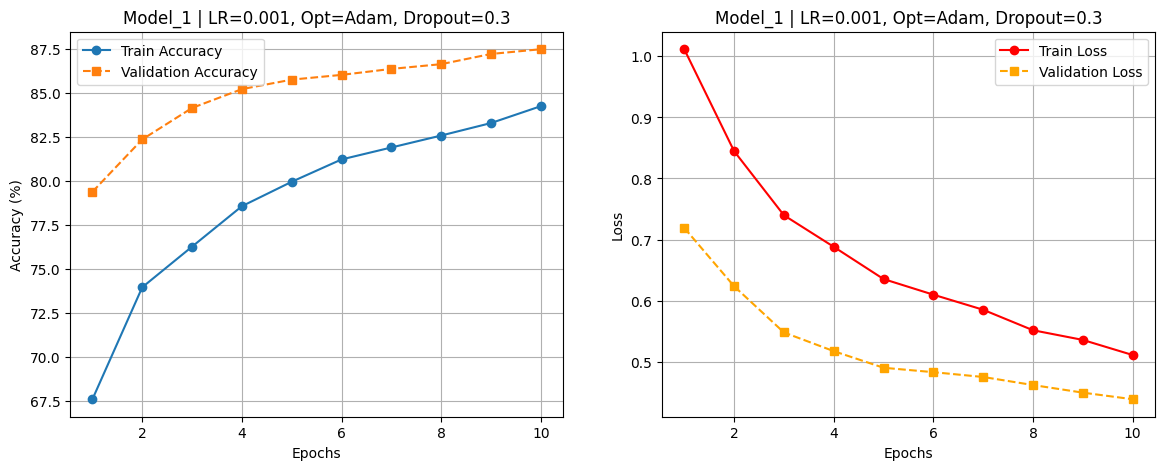

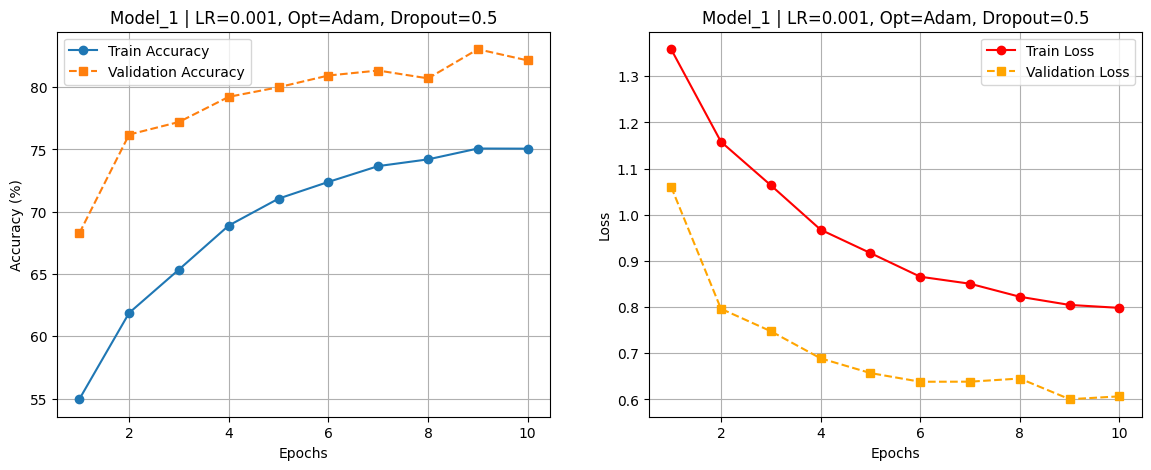

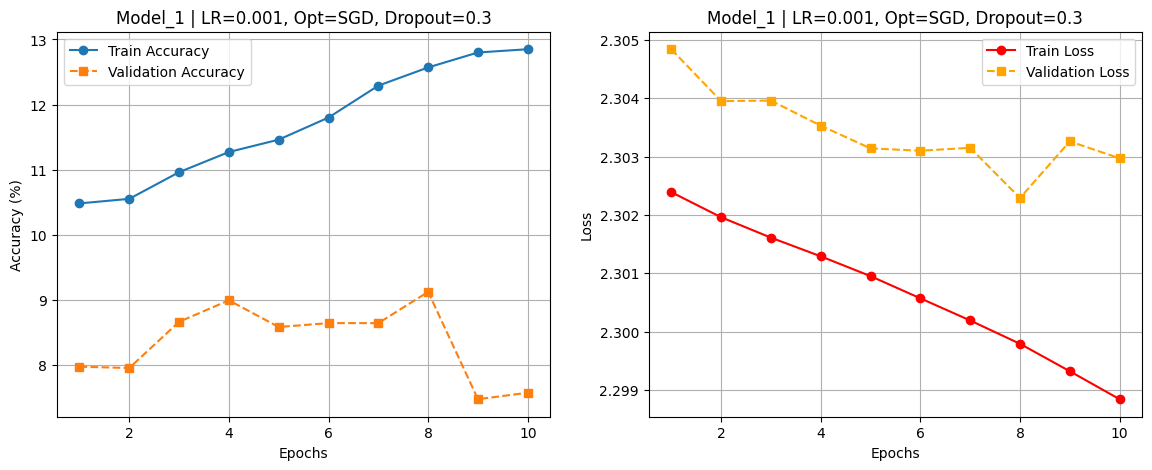

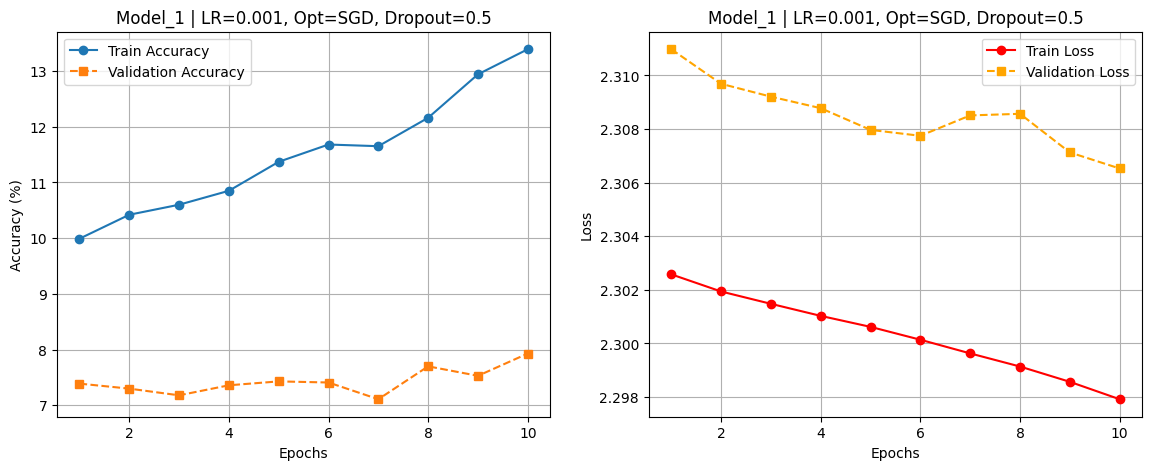

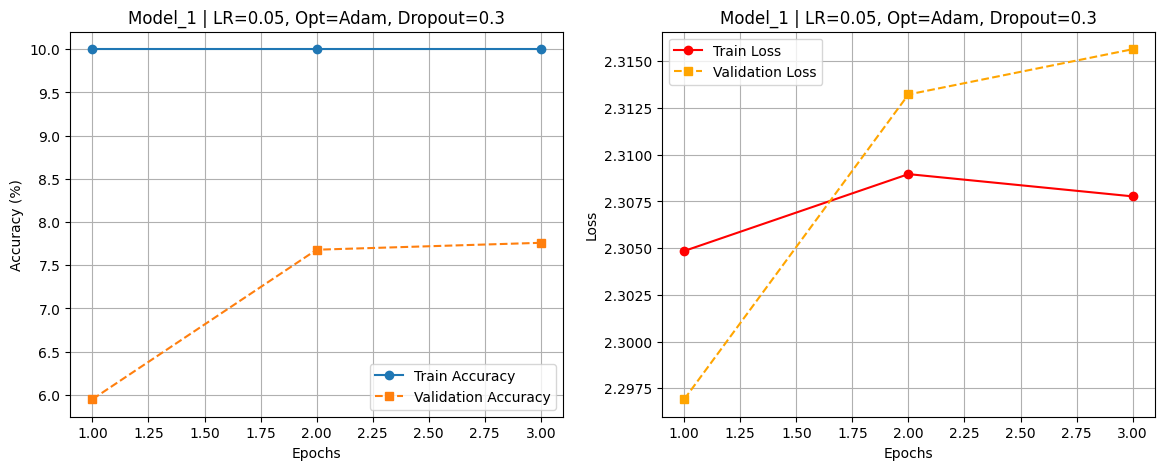

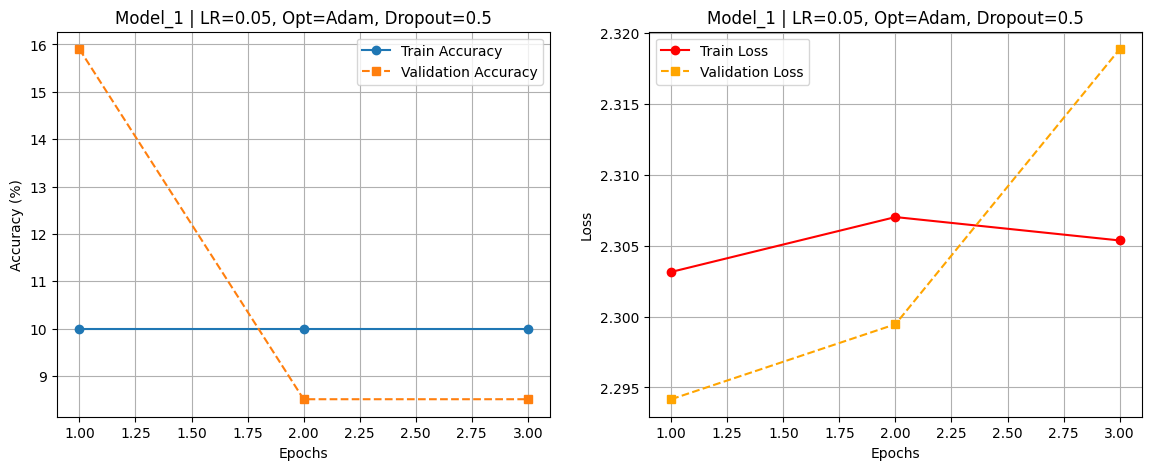

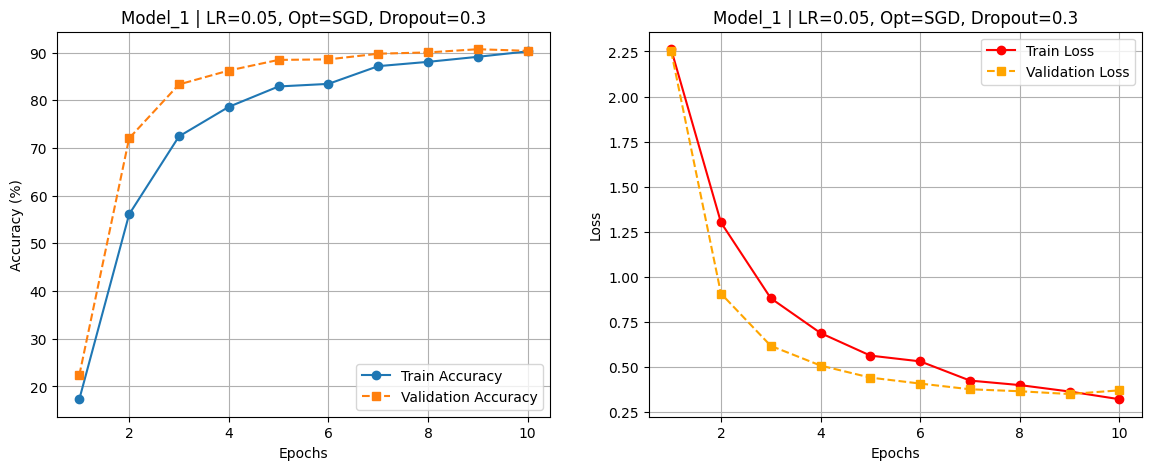

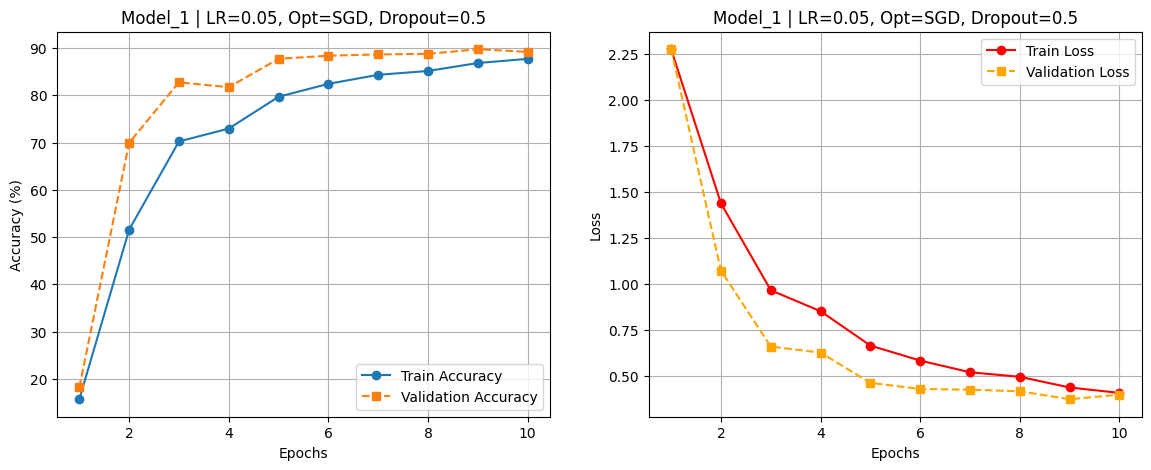

In [167]:
for i, (lr, opt, dropout) in enumerate(itertools.product(learning_rates, optimizers, dropout_rates)):

    model_name, results = train_history[i]
    
    epochs = list(range(1, len(results["train_acc"]) + 1))

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    axes[0].plot(epochs, results["train_acc"], label="Train Accuracy", marker='o')
    axes[0].plot(epochs, results["val_acc"], label="Validation Accuracy", marker='s', linestyle="dashed")
    axes[0].set_title(f"{model_name} | LR={lr}, Opt={opt}, Dropout={dropout}")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].legend()
    axes[0].grid(True)

    # loss plot
    axes[1].plot(epochs, results["train_loss"], label="Train Loss", marker='o', color='red')
    axes[1].plot(epochs, results["val_loss"], label="Validation Loss", marker='s', linestyle="dashed", color='orange')
    axes[1].set_title(f"{model_name} | LR={lr}, Opt={opt}, Dropout={dropout}")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(True)

    plt.show()

In [151]:
lr = 0.001
opt = optim.Adam
dropout = 0.3

print(f"\nsqueezenet1_0| LR={lr}, Optimizer={opt.__name__}, Dropout={dropout}")

model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
model.features[0] = nn.Conv2d(1, 96, kernel_size=3, stride=2, padding=1, bias=False)

model.classifier = nn.Sequential(
    nn.Dropout(p=dropout),  
    nn.Conv2d(512, 10, kernel_size=1),  # change the output to 10 classes
    nn.AdaptiveAvgPool2d(1),  
    nn.Flatten()  # transform into (batch, 10)
)

trained_model, history = train_and_evaluate(model, opt, lr)

squeezenet = [(f"squeezenet1_0_LR{lr}_Opt{opt.__name__}", trained_model, history)]


squeezenet1_0| LR=0.001, Optimizer=Adam, Dropout=0.3
Epoch 1 | Train Accuracy: 10.00% | Loss: 2.30261
Validation Accuracy: 9.91% | Loss: 2.30233
Epoch 2 | Train Accuracy: 10.00% | Loss: 2.30261
Validation Accuracy: 6.68% | Loss: 2.30281


2025-03-10 21:09:06,468 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 3 | Train Accuracy: 10.00% | Loss: 2.30263


2025-03-10 21:09:13,995 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Accuracy: 5.95% | Loss: 2.30512


In [147]:
# Here I misunderstood the task. I thought that I had to greed search t different hyperparameters. but the results are surprising
squeezenet = []
for lr, opt, dropout in itertools.product(learning_rates, optimizers, dropout_rates):
    print(f"\nsqueezenet1_0| LR={lr}, Optimizer={opt.__name__}, Dropout={dropout}")
    model = models.squeezenet1_0(weights=models.SqueezeNet1_0_Weights.IMAGENET1K_V1)
    model.features[0] = nn.Conv2d(1, 96, kernel_size=3, stride=2, padding=1, bias=False)
    
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout),  
    nn.Conv2d(512, 10, kernel_size=1),  # change the output to 10 classes
    nn.AdaptiveAvgPool2d(1),  
    nn.Flatten()  # transform into (batch, 10)
    )

    trained_model, history = train_and_evaluate(model, opt, lr)
    squeezenet.append((f"squeezenet1_0{lr}_Opt{opt.__name__}", trained_model, history))



squeezenet1_0| LR=0.001, Optimizer=Adam, Dropout=0.3
Epoch 1 | Train Accuracy: 10.14% | Loss: 2.30293
Validation Accuracy: 9.16% | Loss: 2.29681
Epoch 2 | Train Accuracy: 10.00% | Loss: 2.30260
Validation Accuracy: 7.76% | Loss: 2.30373
Epoch 3 | Train Accuracy: 17.14% | Loss: 2.21487
Validation Accuracy: 22.49% | Loss: 2.19641
Epoch 4 | Train Accuracy: 68.22% | Loss: 0.94844
Validation Accuracy: 77.13% | Loss: 0.72600
Epoch 5 | Train Accuracy: 78.53% | Loss: 0.66439
Validation Accuracy: 84.75% | Loss: 0.52602
Epoch 6 | Train Accuracy: 81.55% | Loss: 0.57568
Validation Accuracy: 86.06% | Loss: 0.46245
Epoch 7 | Train Accuracy: 83.78% | Loss: 0.51196
Validation Accuracy: 87.92% | Loss: 0.43037
Epoch 8 | Train Accuracy: 85.36% | Loss: 0.46831
Validation Accuracy: 88.25% | Loss: 0.41132


Engine run is terminating due to exception: 


KeyboardInterrupt: 